In [68]:
from collections import defaultdict
from urllib.parse import urlparse
from tqdm import tqdm_notebook
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import pandas as pd
import requests
import random
import json
import time
import re

In [139]:
from requests.adapters import HTTPAdapter
from requests.packages.urllib3.util.retry import Retry

session = requests.Session()
retry = Retry(connect=1, backoff_factor=0.5)
adapter = HTTPAdapter(max_retries=retry)
session.mount('http://', adapter)
session.mount('https://', adapter)

In [212]:
def get_soup(url):
    global session
    req = session.get(url)
    if req.status_code == 200:
        html = req.text
        html = re.sub('&quot;', '', html)
        soup = BeautifulSoup(html, 'lxml')
        return soup
    return None


# Данные 

In [6]:
path = 'ingredients_from_eda.ru.csv'
data = pd.read_csv(path)

In [61]:
data.head()

,id,ingredient,amount,name,type,page
0,13411,Вода,1 л,kapusta-po-gruzinski-137009,zagotovki,1
1,13410,Сахар,90 г,kapusta-po-gruzinski-137009,zagotovki,1
2,13421,Соль,12 г,kapusta-po-gruzinski-137009,zagotovki,1
3,14585,Уксус 9%-ный,250 мл,kapusta-po-gruzinski-137009,zagotovki,1
4,13436,Белокочанная капуста,1 штука,kapusta-po-gruzinski-137009,zagotovki,1


# Выкачка

In [213]:
def parse_ingredients(salat_name, recipes):
    global base_url
    url = base_url.format(salat_name)
    soup = get_soup(url)
    ingrd_lists = soup.find_all('div', class_="ingredients-list__content")
    ingrd_lists = ingrd_lists[0]
    for ingredient in ingrd_lists:
        if ingredient.name == 'p':
            ingredient = json.loads(ingredient.attrs['data-ingredient-object'])
            recipes['name'].append(salat_name)
            for field in ingredient:
                if field == 'name': col = 'ingredient'
                else: col = field
                recipes[col].append(ingredient[field])

In [158]:
# def get_type(soup):
#     all_cats = soup.find_all('div', class_='recipe__title')[0]
#     url = all_cats.find_all('li')[1]
#     urlp = urlparse(url.a.attrs['href'])
#     cat = urlp.path.split('/')[-1]
#     return cat

In [159]:
base_url = 'https://eda.ru/recepty/salaty/{}'

In [ ]:
recipes = {col:[] for col in ('id', 'ingredient', 'amount', 'name')}
salaty = data[data.type == 'salaty'].name.drop_duplicates()
t_par = tqdm_notebook(salaty)

for name in t_par:
    time.sleep(random.randint(2, 4))
    parse_ingredients(name, recipes)
    

Continue

In [218]:
t_par = tqdm_notebook(list(salaty)[2455:])

for name in t_par:
    time.sleep(random.randint(2, 4))
    parse_ingredients(name, recipes)

KeyboardInterrupt: 

In [223]:
recipes = pd.DataFrame(recipes)
recipes.to_csv('recipes.tsv', sep='\t')

In [224]:
recipes.head()

,id,ingredient,amount,name
0,13420,Перец черный молотый,по вкусу,salat-iz-krasnoj-fasoli-s-tvorozhnim-sirom-kra...
1,13804,Консервированная фасоль,400 г,salat-iz-krasnoj-fasoli-s-tvorozhnim-sirom-kra...
2,13421,Соль,по вкусу,salat-iz-krasnoj-fasoli-s-tvorozhnim-sirom-kra...
3,13427,Лимон,1 штука,salat-iz-krasnoj-fasoli-s-tvorozhnim-sirom-kra...
4,13430,Чеснок,2 зубчика,salat-iz-krasnoj-fasoli-s-tvorozhnim-sirom-kra...


# Салаты

In [2]:
data = pd.read_csv('/Users/Stoneberry/Desktop/recipes.tsv', sep='\t')

In [3]:
data.head()

,Unnamed: 0,id,ingredient,amount,name
0,0,13420,Перец черный молотый,по вкусу,salat-iz-krasnoj-fasoli-s-tvorozhnim-sirom-kra...
1,1,13804,Консервированная фасоль,400 г,salat-iz-krasnoj-fasoli-s-tvorozhnim-sirom-kra...
2,2,13421,Соль,по вкусу,salat-iz-krasnoj-fasoli-s-tvorozhnim-sirom-kra...
3,3,13427,Лимон,1 штука,salat-iz-krasnoj-fasoli-s-tvorozhnim-sirom-kra...
4,4,13430,Чеснок,2 зубчика,salat-iz-krasnoj-fasoli-s-tvorozhnim-sirom-kra...


### cesar

In [ ]:
cesar = data[data['name'].str.contains("-cezar-")]
cesar['cat'] = ['cesar'] * cesar.shape[0]

### rassols

In [ ]:
rassols = data[data['name'].str.contains("-rassols-")]
rassols['cat'] = ['rassols'] * rassols.shape[0]

### shopskiy

In [ ]:
shopskiy = data[data['name'].str.contains("shopskiy-")]
shopskiy['cat'] = ['shopskiy'] * shopskiy.shape[0]

#### Соединяем вместе

In [73]:
df = pd.concat([cesar, rassols, shopskiy])
counts = df[['name', 'cat']].drop_duplicates().groupby('cat').size()
unstacked = df.groupby(['cat', 'ingredient']).size().reset_index()
values = [counts[cat] for cat in unstacked['cat']]
unstacked['n'] = unstacked[0].div(values)

## Визуализация

In [70]:
import seaborn as sns

In [107]:
unstacked = unstacked.pivot_table('n', ['ingredient'], 'cat')
unstacked = unstacked.fillna(0)
unstacked['score'] = unstacked.sum(axis=1)
unstacked = unstacked.sort_values('score', ascending=False)

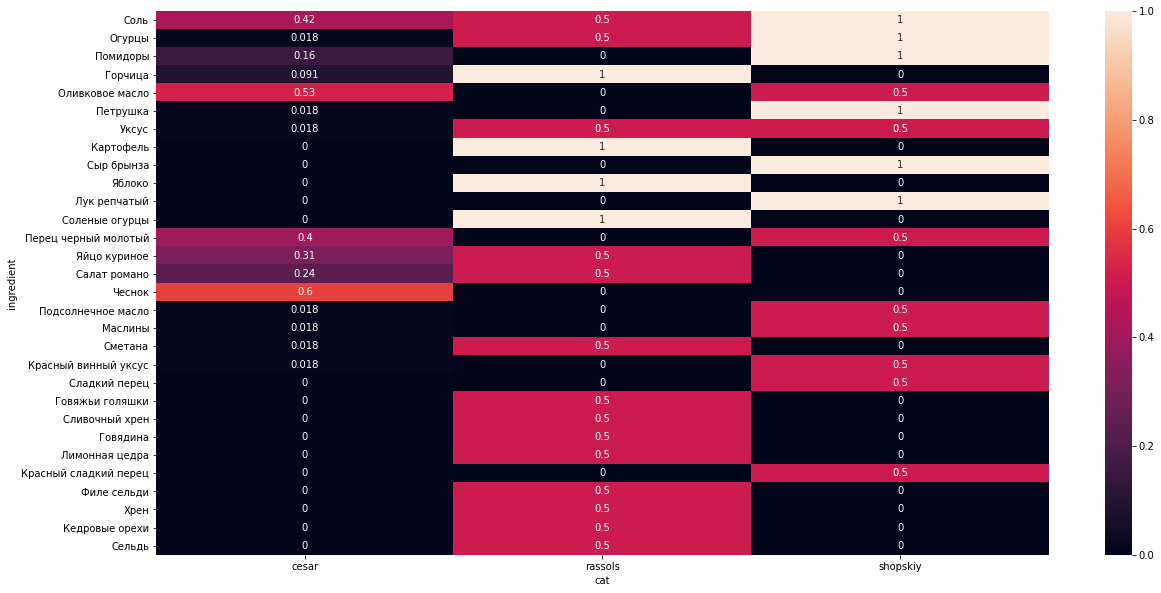

In [127]:
plt.figure(figsize=(20, 10))

sns.heatmap(unstacked[['cesar', 'rassols', 'shopskiy']].head(30), annot=True)